# Χαῖρε, ῶ πάτερ!


# So I appeared to have fixed the issue. For the gate for $q_0$, I forgot to multiply $\alpha_0$ by 2, which apparently makes things spiky. (Maybe a problem worth understanding?)

# The circuit generated is the schema made in the Klco-Savage paper.

# In total, there are $1+2+4+8+...+2^{n-1} = 2^n -1$ total gates. (Too inefficient?)

# Imports below:

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 18 16:55:43 2020

@author: andreas
"""

from qiskit import *
from qiskit.circuit import *
from qiskit.extensions import RYGate
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools

qiskit.__qiskit_version__

{'qiskit-terra': '0.13.0',
 'qiskit-aer': '0.4.0',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.6.0',
 'qiskit-aqua': '0.6.6',
 'qiskit': '0.18.0'}

# Ancillary functions, used to compute the angle.

# "$f(\sigma,\mu)$" is the discrete version of a Gaussian:

# $f(\sigma,\mu) = \sum\limits_{n=-M}^{M} e^{-\frac{(n-\mu)^2}{\sigma}}$ 

# Where M is an arbitrary large number (in our case, 1,000).

 # The rotation angle $\alpha$ is defined as follows:

# $\alpha = \cos^{-1}\left(\sqrt{\frac{f(\sigma/2,\mu/2)}{f(\sigma,\mu)}}\right)$


In [2]:
def g_(sigma_, mu_, lim):
    # normalization function, equal to psi tilde squared, summed over all the integers.
    # in lieu of an infinite sum, we can simply make ``lim" sufficiently high. 
    return np.sum(np.exp((-(np.arange(-lim, lim+1, 1) - mu_)**2)/float((2)*sigma_**2)))


def angle_(sigma_, mu_, lim=10**3):
    # Calculates the angle, based on the square root of probability. 
    # cutoff the infinite sum in g_(...) at 10**3 by default
    return np.arccos(np.sqrt(g_(sigma_/2., mu_/2., lim)/g_(sigma_, mu_, lim)))

def ctrl_states(n):
    states = []
    for i in range(0,2**n):
        s = bin(i).replace("0b", "")
        states.append("".join(["0" for j in range(0,n-len(s))])+s)
    return states
ctrl_states(3)

['000', '001', '010', '011', '100', '101', '110', '111']

In [3]:
'''
def qubit_strings2(n):
    # Given parameter n, generate strings 0-(n-1) in binary.
    qubit_strings = []
    for q in itertools.product(['0', '1'], repeat=n):
        qubit_strings.append(''.join(q))
    return qubit_strings
'''
def new_mu(qub, mu):
    # calculate modified \mu for n-bit string qubit
    # i.e., we have g(b, mu) = (mu - b)/2, b \in {0,1}, and g('',mu) = mu
    # e.g., h('101101', mu) = g('1',g('0',g('1',g(...)))) etc.
    new_mean = mu
    for bit in qub[::-1]:#reversed because we consider the qubits increasingly further back
        new_mean = (new_mean/2.) - ((1/2.)*int(bit))
    return new_mean

# To each qubit, we apply the following rotation matrix:

# $R_y(2\alpha) = \begin{bmatrix}\cos\alpha&-\sin\alpha \\ \sin\alpha & \cos\alpha \end{bmatrix}$

In [4]:
def create_circ(N, mu_, sig_,):
    qr = QuantumRegister(N, 'q')
    qc = QuantumCircuit(qr)# Generate a quantum circuit with a quantum register (list) of qubit objects
    alpha_0 = angle_(sig_, mu_) # We multiply by 2, because the ry gate rotates by alpha/2
    qc.ry(2*alpha_0,0) # apply a rotation angle of alpha_0 (multiply by 2 because gate halves parameter)
    for i in range(1,N): # Steps to be done at level q_i
        qstring = ctrl_states(i) # create list of 2^i strings of length i
        for k in qstring:
            alpha_ = angle_(sig_/(2**i), new_mu(k, mu_)) # Calculate angle using modified mean
            new_gate = RYGate(2*alpha_).control(num_ctrl_qubits = i, 
                                                label = None, 
                                                ctrl_state=k) # control state is 
            qc.append(new_gate, qr[:i+1]) # add ry gate to level

    return qc

# These are the parameters used in the Meduim article. I believe they must  satisfy the inequality  $2^{n-1} - \mu >> \sigma >> 1$

[0.02030149+0.j 0.02079833+0.j 0.02224751+0.j 0.02454891+0.j
 0.02759022+0.j 0.03127888+0.j 0.03555048+0.j 0.04036378+0.j
 0.04569234+0.j 0.05151675+0.j 0.05781893+0.j 0.06457802+0.j
 0.07176757+0.j 0.07935376+0.j 0.08729417+0.j 0.09553724+0.j
 0.10402198+0.j 0.11267829+0.j 0.12142744+0.j 0.13018299+0.j
 0.138852  +0.j 0.1473365 +0.j 0.15553523+0.j 0.16334559+0.j
 0.17066568+0.j 0.17739654+0.j 0.1834443 +0.j 0.18872241+0.j
 0.19315361+0.j 0.19667192+0.j 0.19922416+0.j 0.20077138+0.j
 0.20128978+0.j 0.20077138+0.j 0.19922416+0.j 0.19667192+0.j
 0.19315361+0.j 0.18872241+0.j 0.1834443 +0.j 0.17739654+0.j
 0.17066568+0.j 0.16334559+0.j 0.15553523+0.j 0.1473365 +0.j
 0.138852  +0.j 0.13018299+0.j 0.12142744+0.j 0.11267829+0.j
 0.10402198+0.j 0.09553724+0.j 0.08729417+0.j 0.07935376+0.j
 0.07176757+0.j 0.06457802+0.j 0.05781893+0.j 0.05151675+0.j
 0.04569234+0.j 0.04036378+0.j 0.03555048+0.j 0.03127888+0.j
 0.02759022+0.j 0.02454891+0.j 0.02224751+0.j 0.02079833+0.j]
sum: (0.999999999999969

C:\Users\andre\Anaconda3\envs\shlab\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


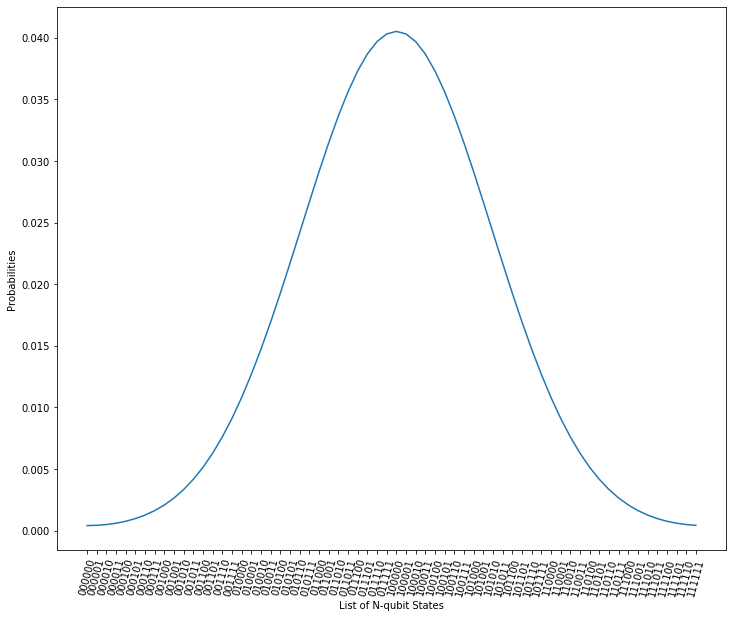

In [37]:
N = 6
sigma = 2**N/6.5
mu = 2**(N-1)

qc = create_circ(N,mu,sigma)


backend = Aer.get_backend('statevector_simulator')
state = execute(qc, backend).result().get_statevector()

print(state)

probs = [x*x for x in state]

print('sum: ' + str(sum(probs)))

# plot the probabilities
wavefcn_xlist = list(ctrl_states(N))
wavefcn_ylist = list(probs)
plt.figure(figsize=(12, 10))
plt.plot(range(len(wavefcn_ylist)), wavefcn_ylist)
plt.xticks(range(len(wavefcn_xlist)), wavefcn_xlist, rotation=75)
plt.xlabel('List of N-qubit States')
plt.ylabel('Probabilities')
plt.show()